# STATS 601: Microenvironment ECMP Analysis
## Team Members: Aaron Abkemeier, Unique Subedi, Victor Verma, Yash Patel

### Setup
We begin by loading in the data and relevant packages. Of note is that we load the plates all into memory and store the indexing across the staining sets in a later referenced variable `staining_sets`

In [277]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import collections
import os
from scipy.ndimage.filters import gaussian_filter


/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_92276/1858621319.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [183]:
plates = {f"plate{fn[6:9]}": pd.read_csv(os.path.join("Data", fn), sep = '\t') for fn in os.listdir("Data")}
full_plates = sorted(list(plates.keys()))

num_stain_sets = 3
staining_set_size = 8
staining_sets = [full_plates[staining_set_size * stain_idx:staining_set_size * (stain_idx + 1)] for stain_idx in range(num_stain_sets)]

In [232]:
key_properties_to_cols = {
    "count": "Spot_PA_SpotCellCount",
    # "cell_area": "Cells_CP_AreaShape_Area", # this is missing in some plates? TODO: find out why
    # "cytoplasm_area": "Cytoplasm_CP_AreaShape_Area", # same here
    "nuclear_area": "Nuclei_CP_AreaShape_Area",
}

def populate_property_minmax(col_name):
    min_prop = np.min([np.min([plates[plate_name][col_name].min() for plate_name in staining_set]) for staining_set in staining_sets])
    max_prop = np.max([np.max([plates[plate_name][col_name].max() for plate_name in staining_set]) for staining_set in staining_sets])
    property_to_min_max[col_name] = (min_prop, max_prop)

property_to_min_max = {}
for key_property in key_properties_to_cols:
    populate_property_minmax(key_properties_to_cols[key_property])

### Basic Data Visualization
We now do basic visualization of the data in the well structure it was collected in. Partitions are drawn for the wells within a given plate. Some observations are revealed through that and visualizing distributions. One is that supposedly equivalent plates across staining sets are *not* distributed evenly in terms of absolute cell counts: we normalize the data, therefore, before doing analysis (later section).

In [282]:
sns.set_style("whitegrid")
plt.rcParams['text.usetex'] = True
plt.rcParams["axes.grid"] = False
blue, = sns.color_palette("muted", 1)

# arghh, got these +1s and -1s floating around cause the data's 1 indexed...
def gen_well_viz_property(plate, well_idx, property):
    well = plate[plate["WellIndex"] == well_idx + 1]
    well_rows, well_cols = 35, 20
    well_heatmap = np.zeros((well_rows, well_cols))
    well_heatmap[well["ArrayRow"] - 1, well["ArrayColumn"] - 1] = well[property]
    return well_heatmap

def viz_well(well_heatmap):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
    sns.heatmap(well_heatmap, ax=ax)
    plt.show()

def viz_plate_property(plate, property, viz_blur=False):    
    fig, axs = plt.subplots(2, 4, figsize=(16, 8), dpi=120)
    plt.subplots_adjust(wspace=0, hspace=0)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    well_heatmaps = [gen_well_viz_property(plate, well_idx, property) for well_idx in range(8)]
    min_prop, max_prop = property_to_min_max[property]
    well_rows, well_cols = 35, 20

    # for well_idx, well_heatmap in enumerate(well_heatmaps):
    for well_idx, ax in enumerate(axs.flat):
        well_row, well_col = well_idx // 4, well_idx % 4
        ax = axs[well_row, well_col]

        ax.axhline(y=0, color='k',linewidth=3)
        ax.axhline(y=well_rows, color='k',linewidth=3)
        ax.axvline(x=0, color='k',linewidth=3)
        ax.axvline(x=well_cols, color='k',linewidth=3)

        viz_heatmap = well_heatmaps[well_idx]
        if viz_blur:
            viz_heatmap = gaussian_filter(viz_heatmap, sigma=3)

        sns.heatmap(
            viz_heatmap, ax=ax, vmin=min_prop, vmax=max_prop, linewidths=1, 
            linecolor='black', xticklabels=False, yticklabels=False, 
            cbar=(well_idx == 0), cbar_ax=None if well_idx else cbar_ax
        )
    plt.show()

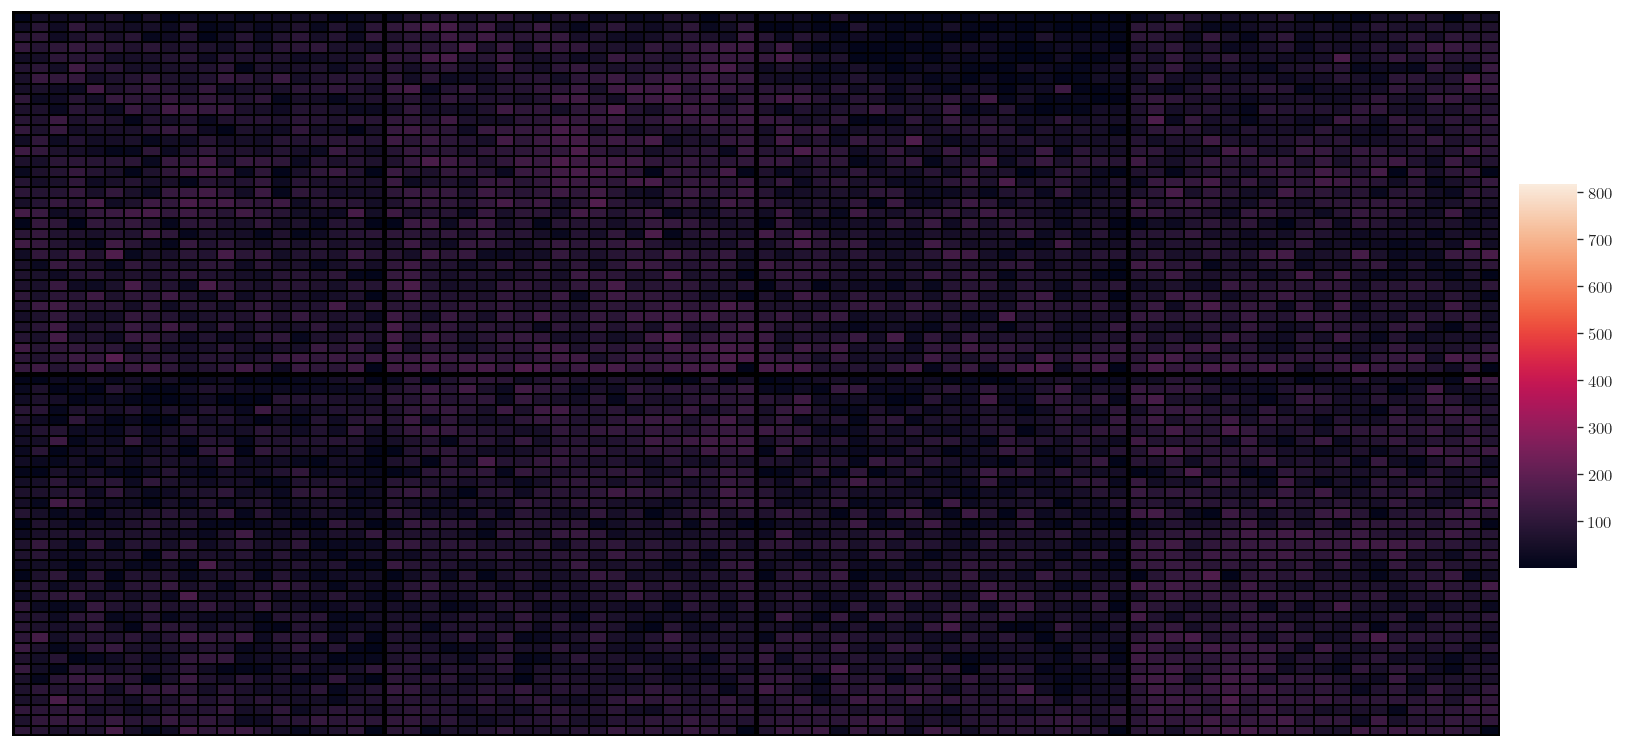

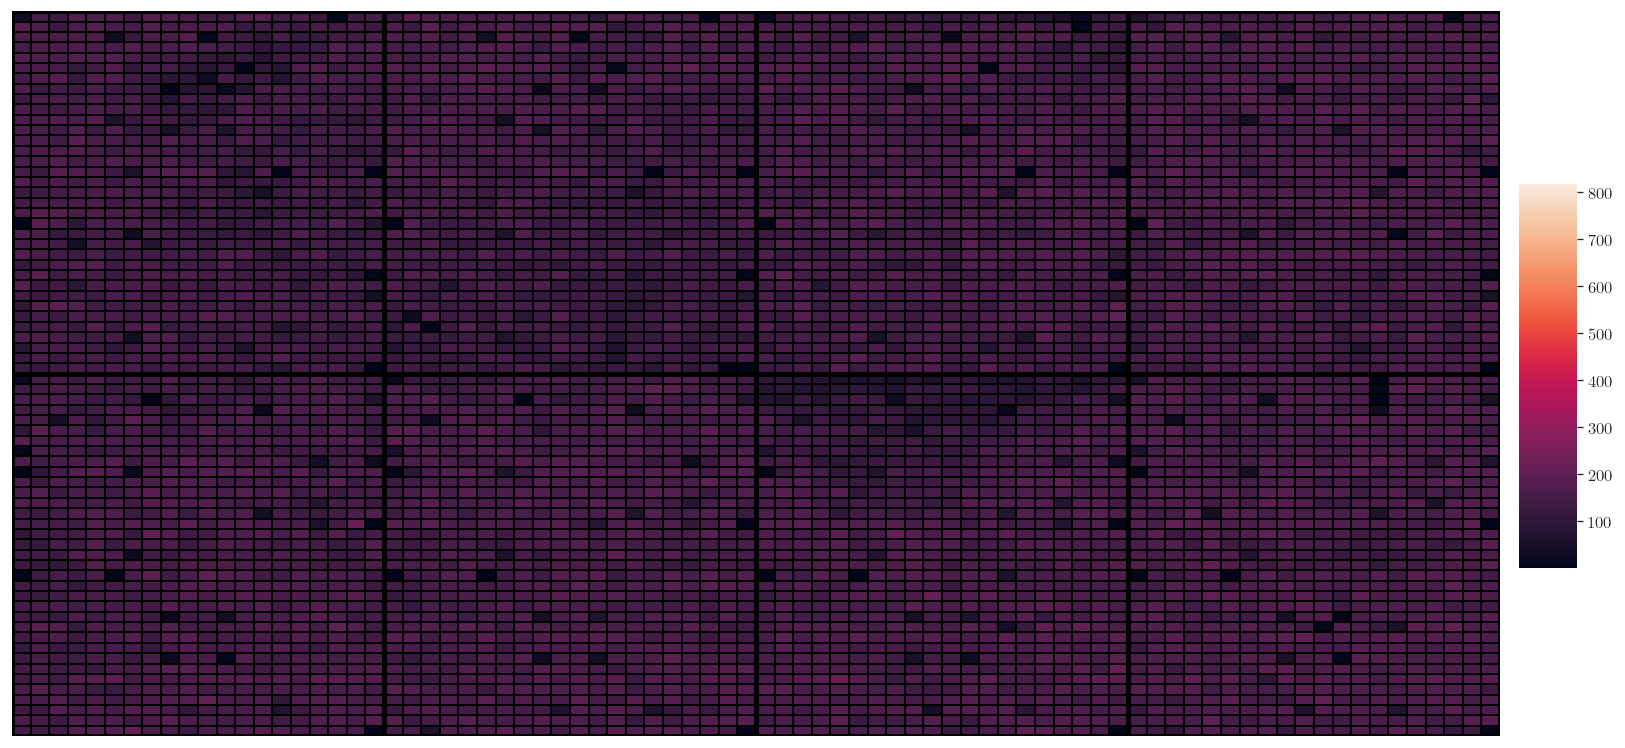

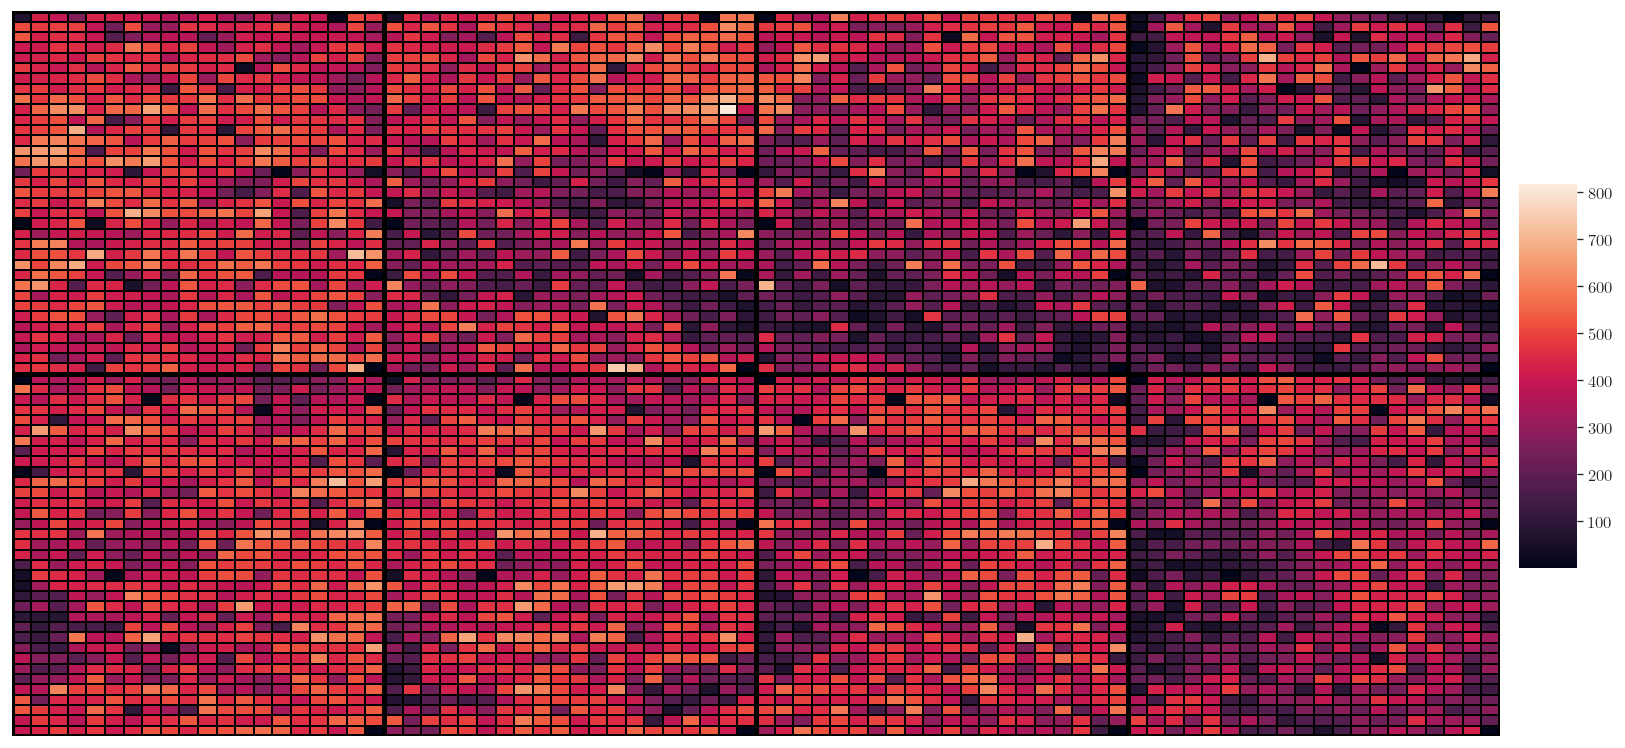

In [188]:
# NOTE: these supposedly "equivalent" staining sets are definitely not -- need to normalize the counts/properties for analysis
for staining_set in staining_sets:
    cur_plate = plates[staining_set[1]]
    viz_plate_property(cur_plate, key_properties_to_cols["count"])

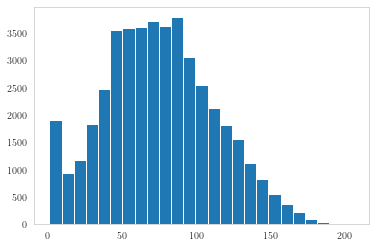

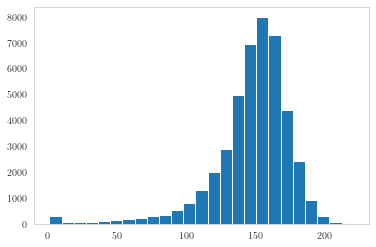

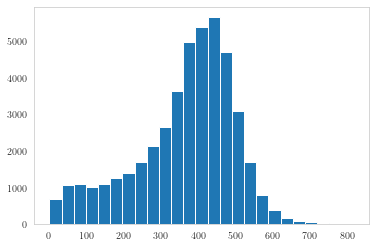

In [220]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name][key_properties_to_cols["count"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    plt.hist(full_counts, bins=25)
    plt.show()

### Data Transformations

In [233]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name][key_properties_to_cols["count"]] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    full_mean = np.mean(full_counts)
    full_std = np.std(full_counts)
    
    for plate_name in staining_set:
        plates[plate_name]["std_count"] = (plates[plate_name][key_properties_to_cols["count"]] - full_mean) / full_std
populate_property_minmax("std_count")

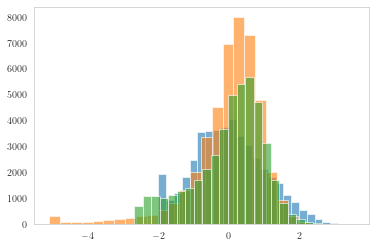

In [234]:
for staining_set in staining_sets:
    staining_set_counts = [plates[plate_name]["std_count"] for plate_name in staining_set]
    full_counts = np.concatenate(staining_set_counts)
    plt.hist(full_counts, bins=25, alpha=0.6)

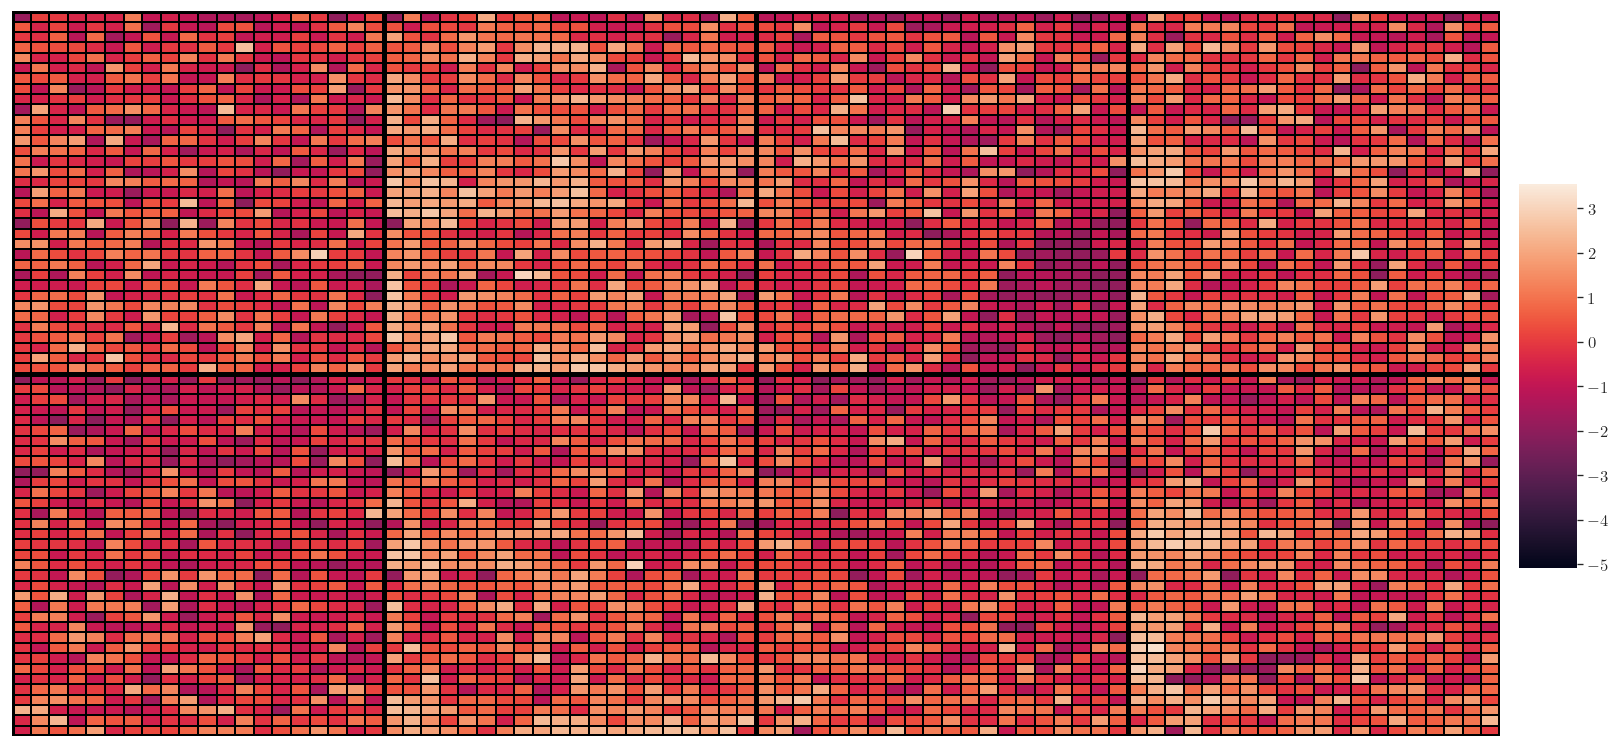

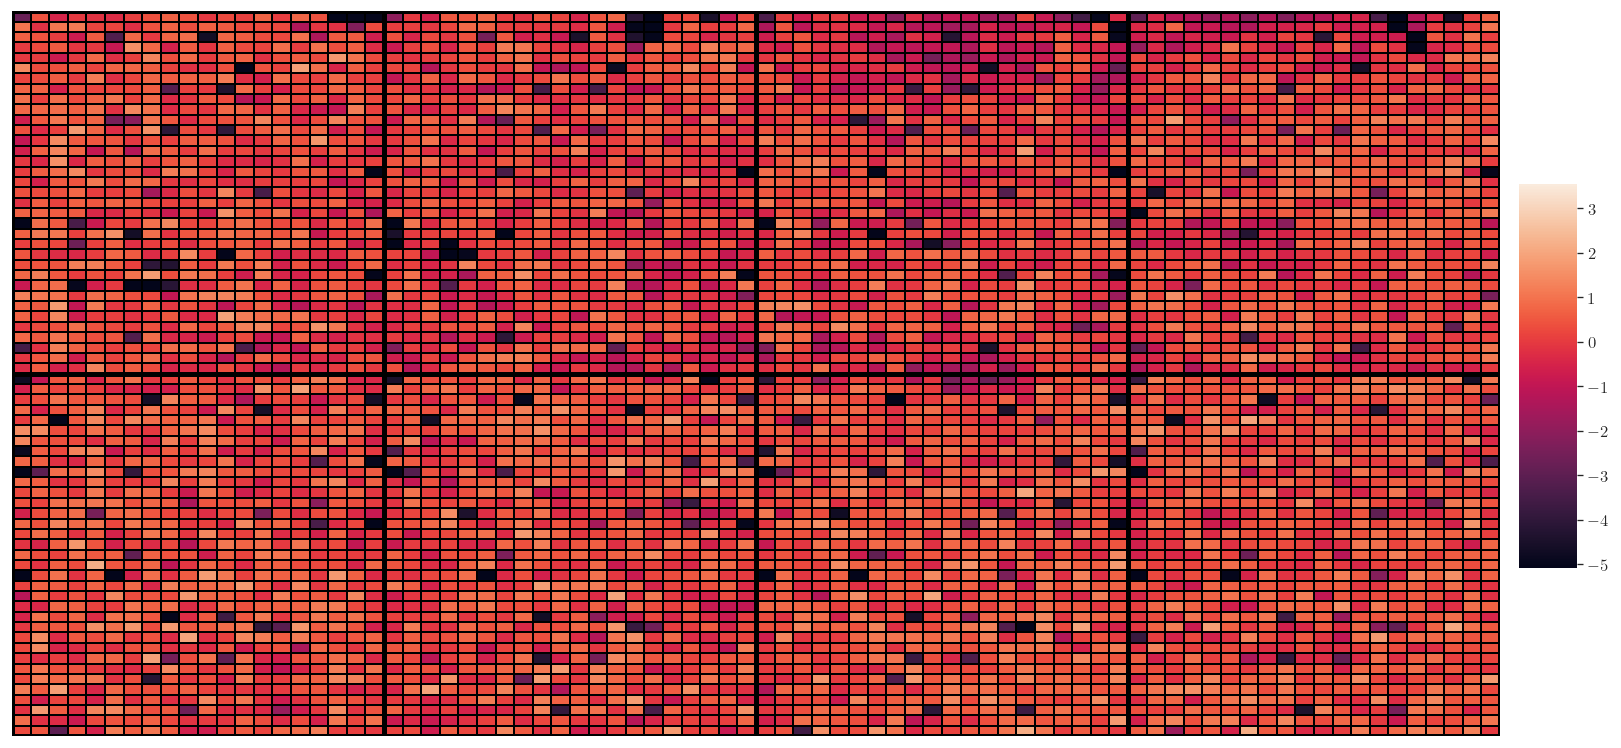

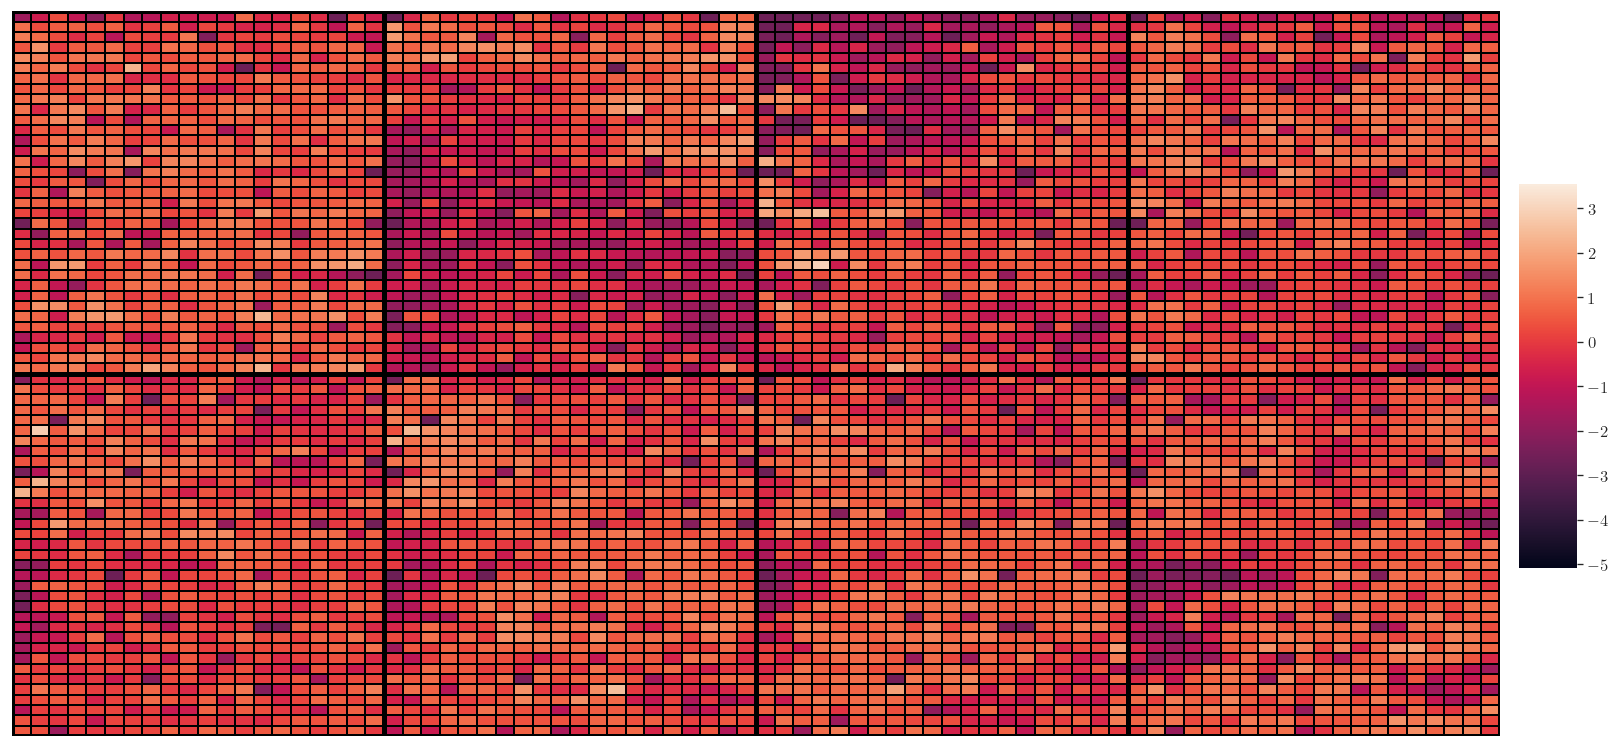

In [248]:
# NOTE: these supposedly "equivalent" staining sets are definitely not -- need to normalize the counts/properties for analysis
for staining_set in staining_sets:
    cur_plate = plates[staining_set[3]]
    viz_plate_property(cur_plate, "std_count")

Spatial analysis of a normalized count reveals that the corners (looking at staining sets 2 and 3) occasionally have some effect where cell counts are reduced. Unclear what the cause is, but this seems fairly repeated across a number of the wells.

In [296]:
for staining_set in staining_sets:
    for plate_name in staining_set:
        plates[plate_name]["thresh_count"] = (plates[plate_name]["std_count"] < -2.5).astype(np.float32)
populate_property_minmax("thresh_count")

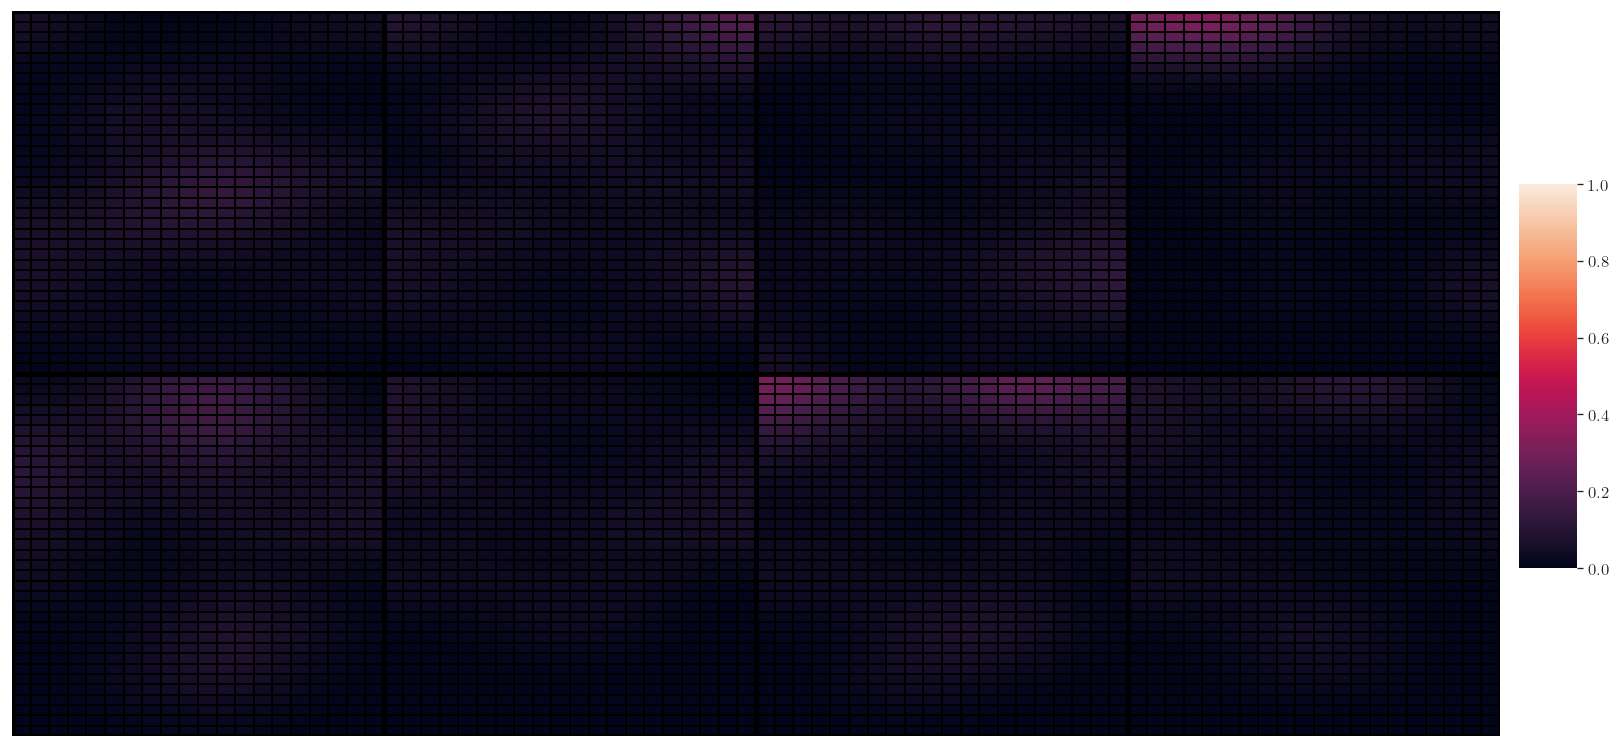

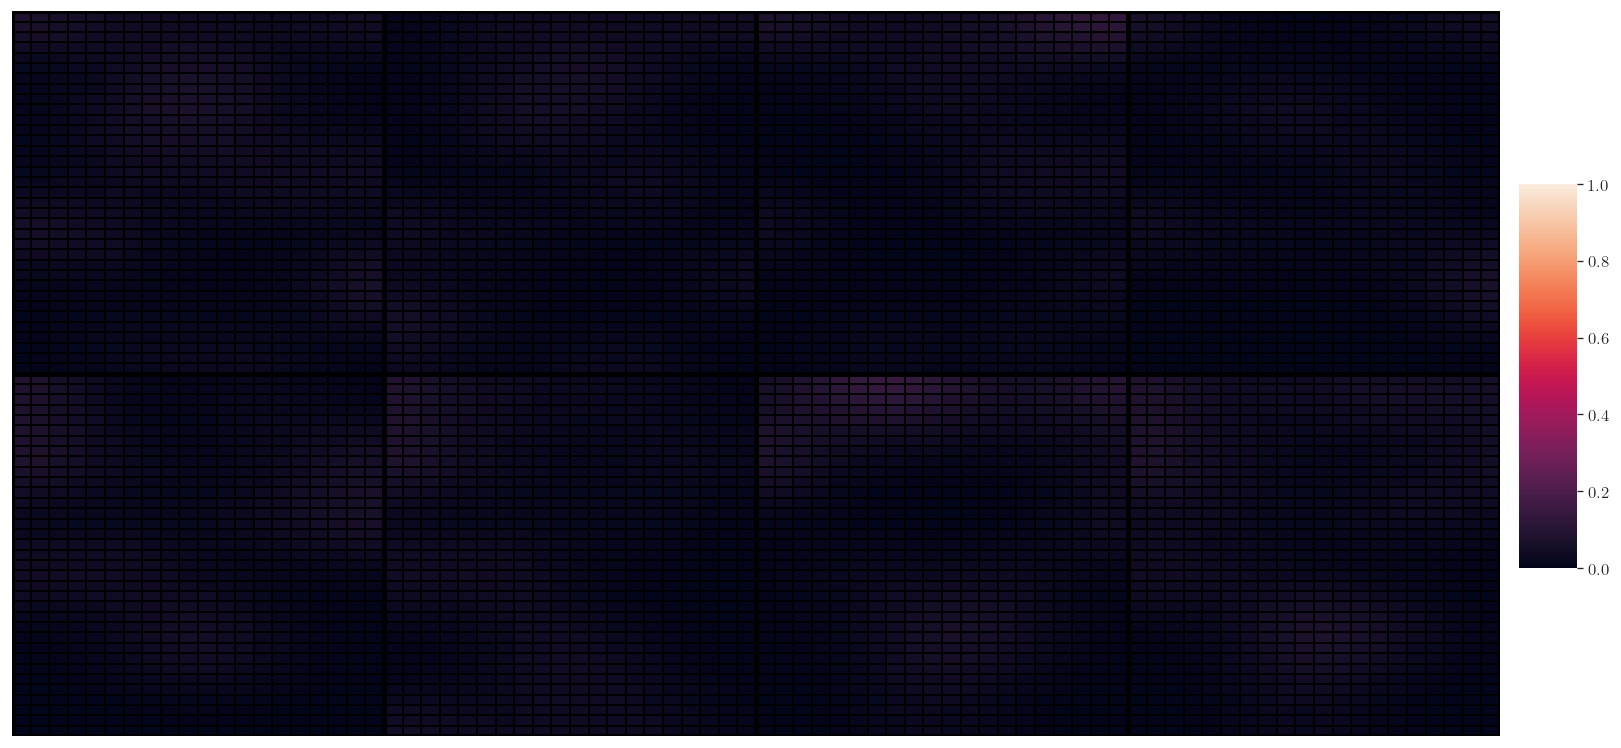

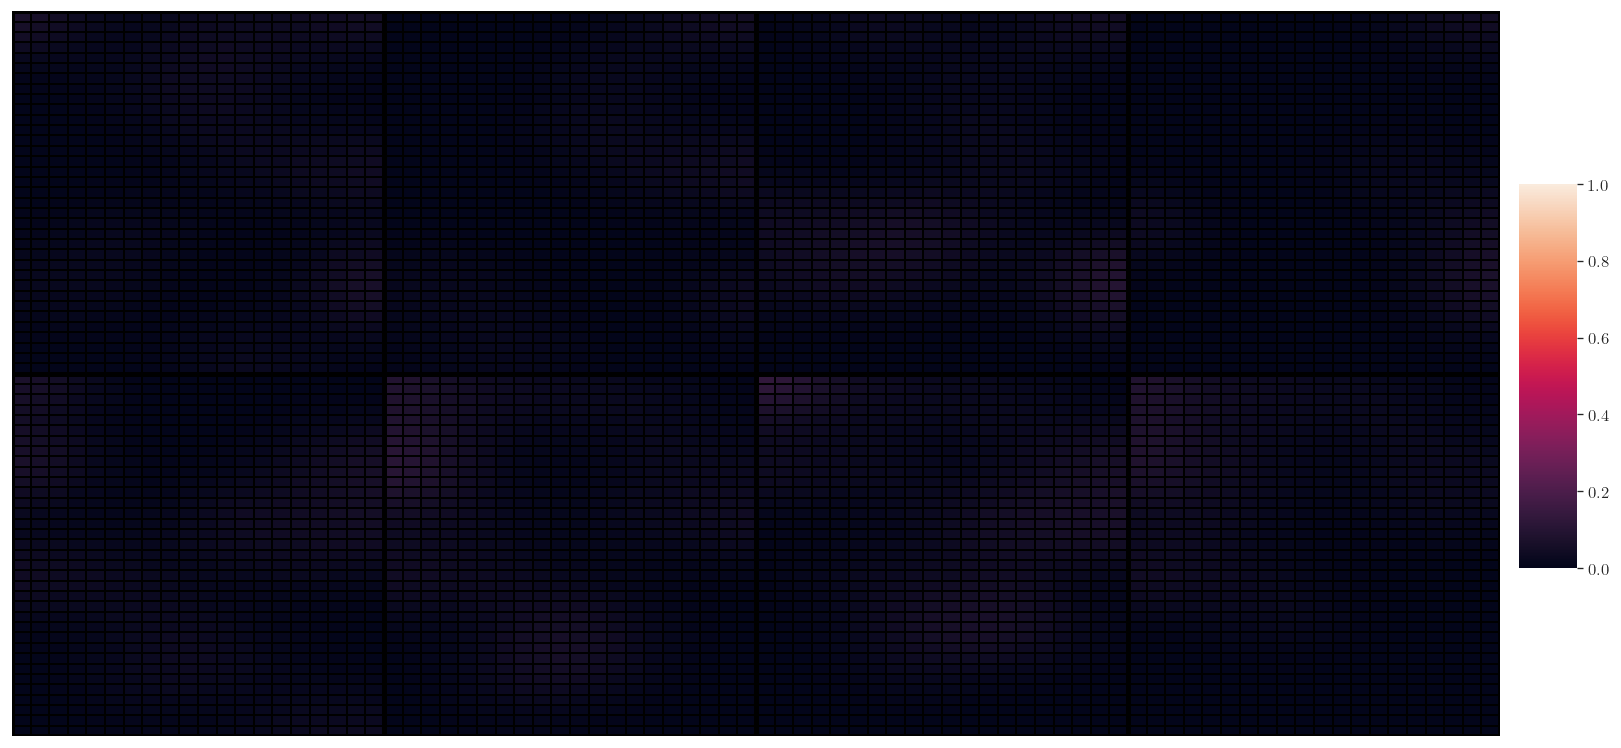

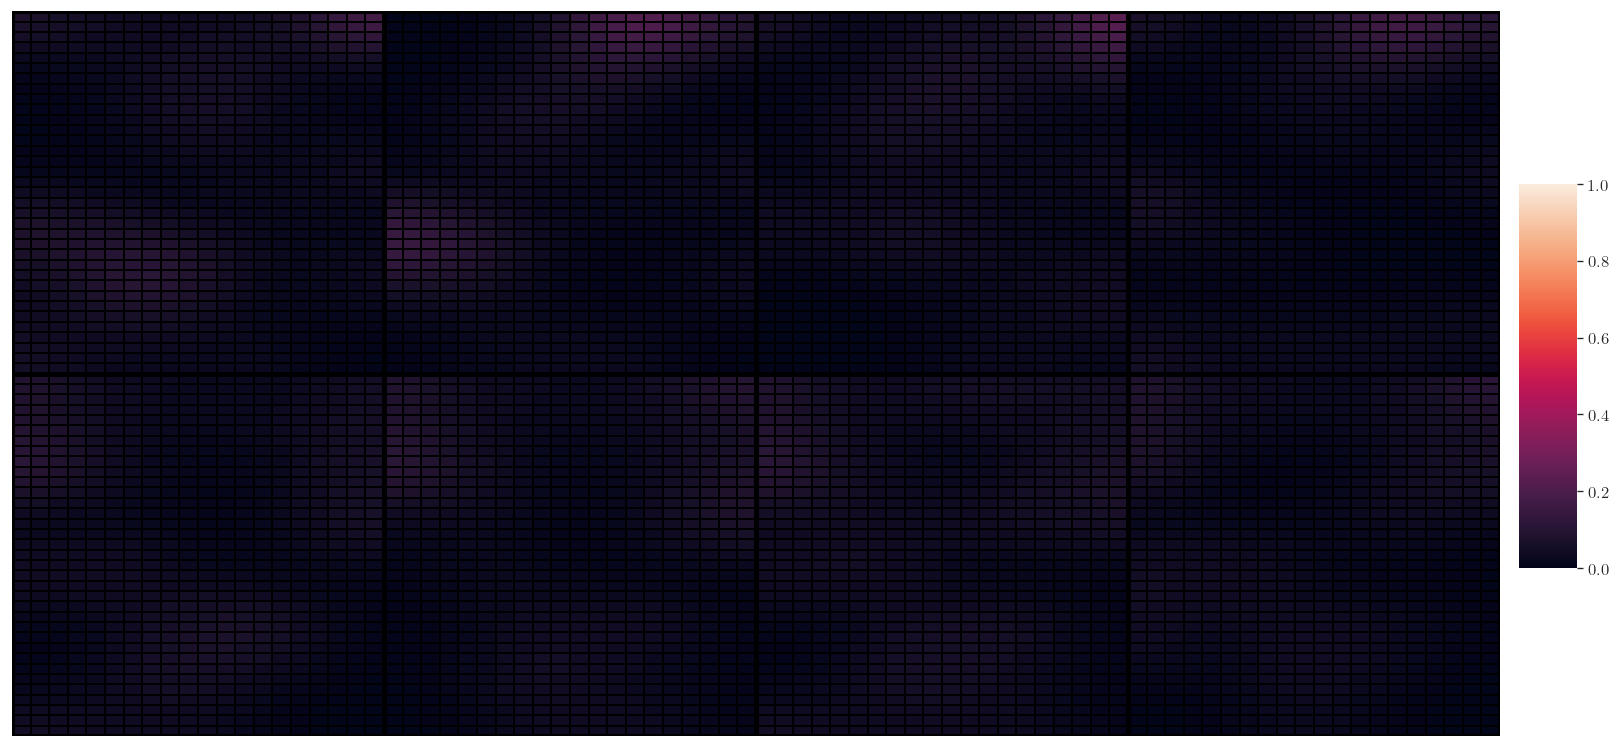

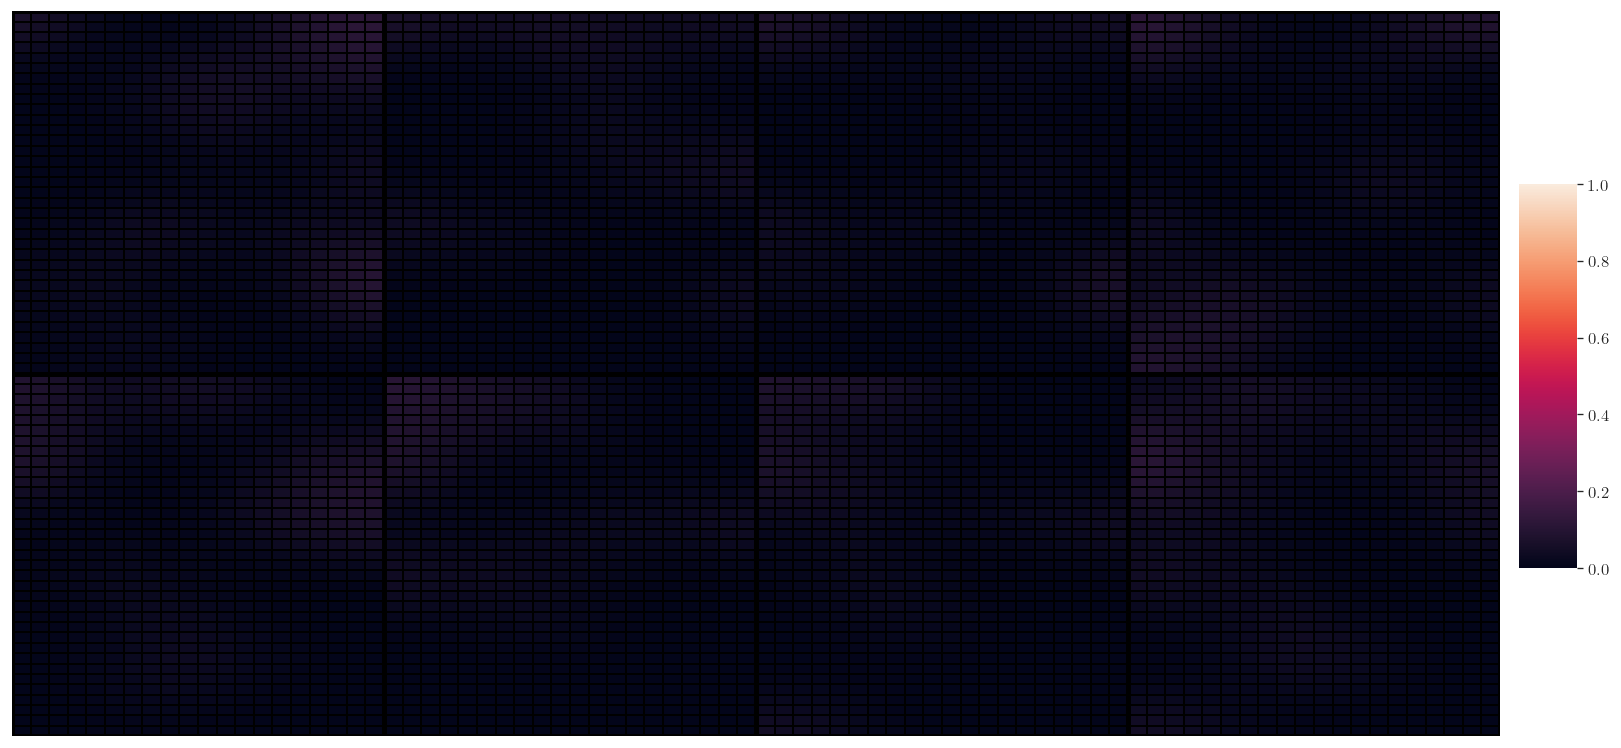

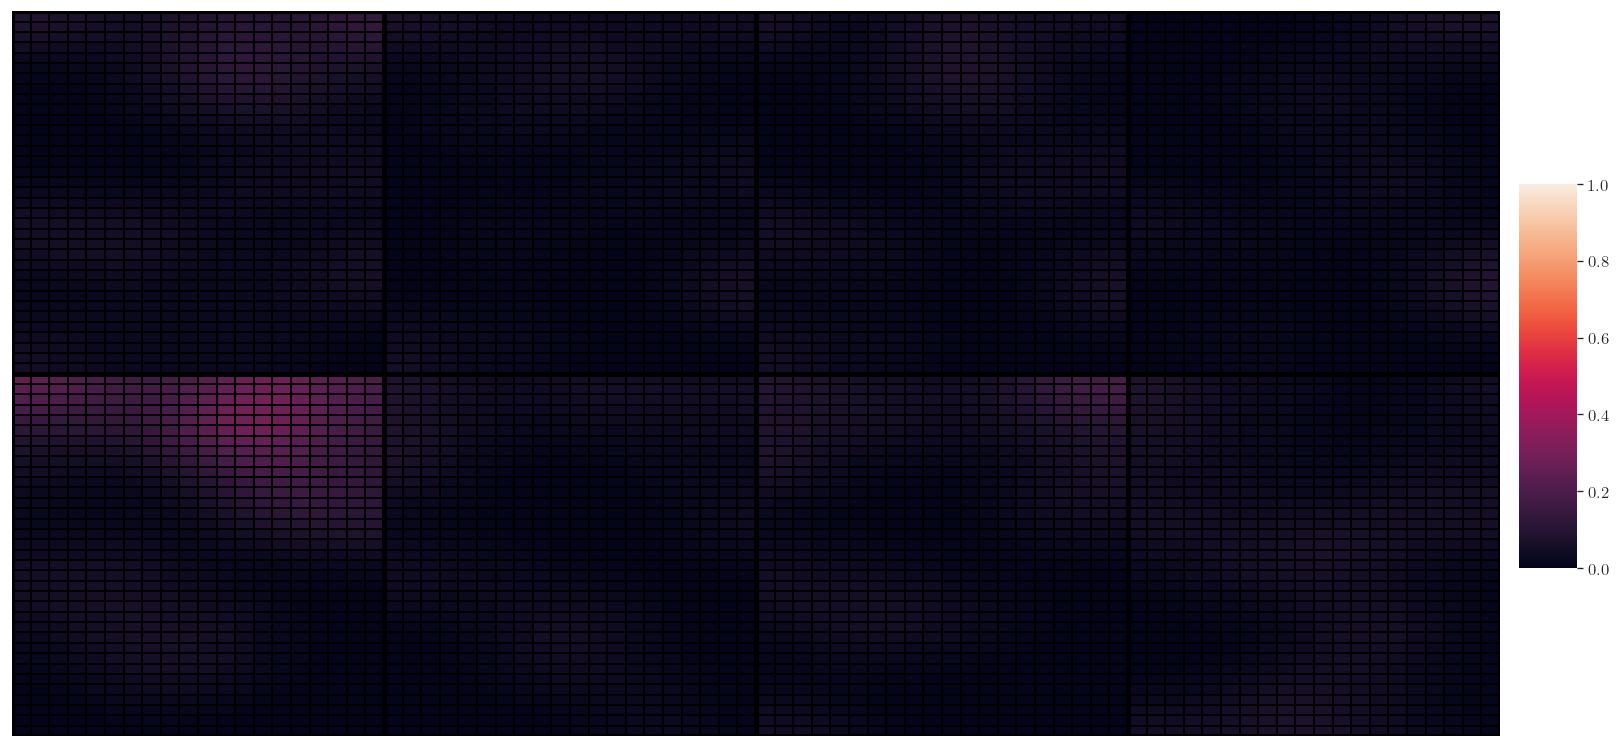

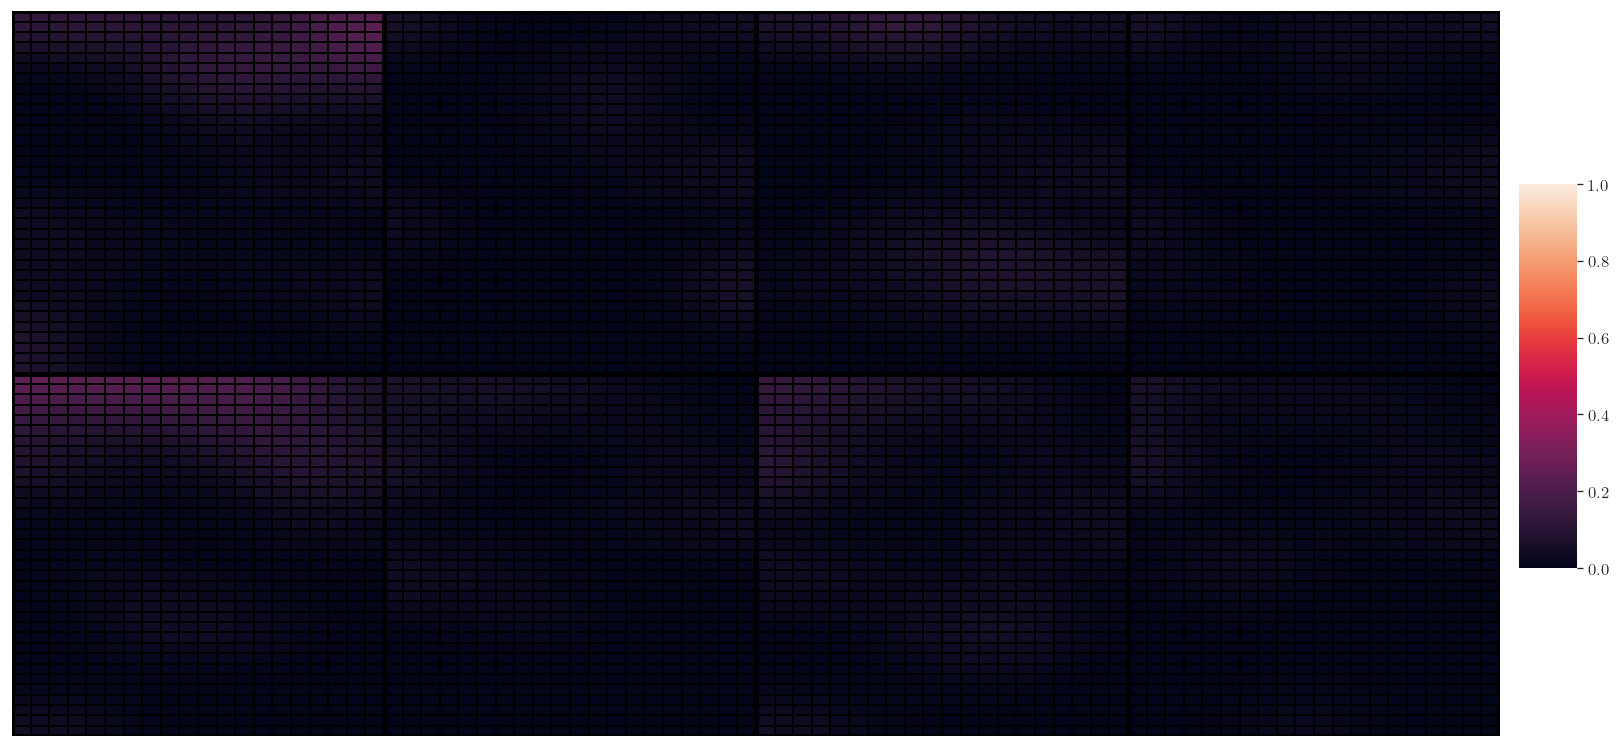

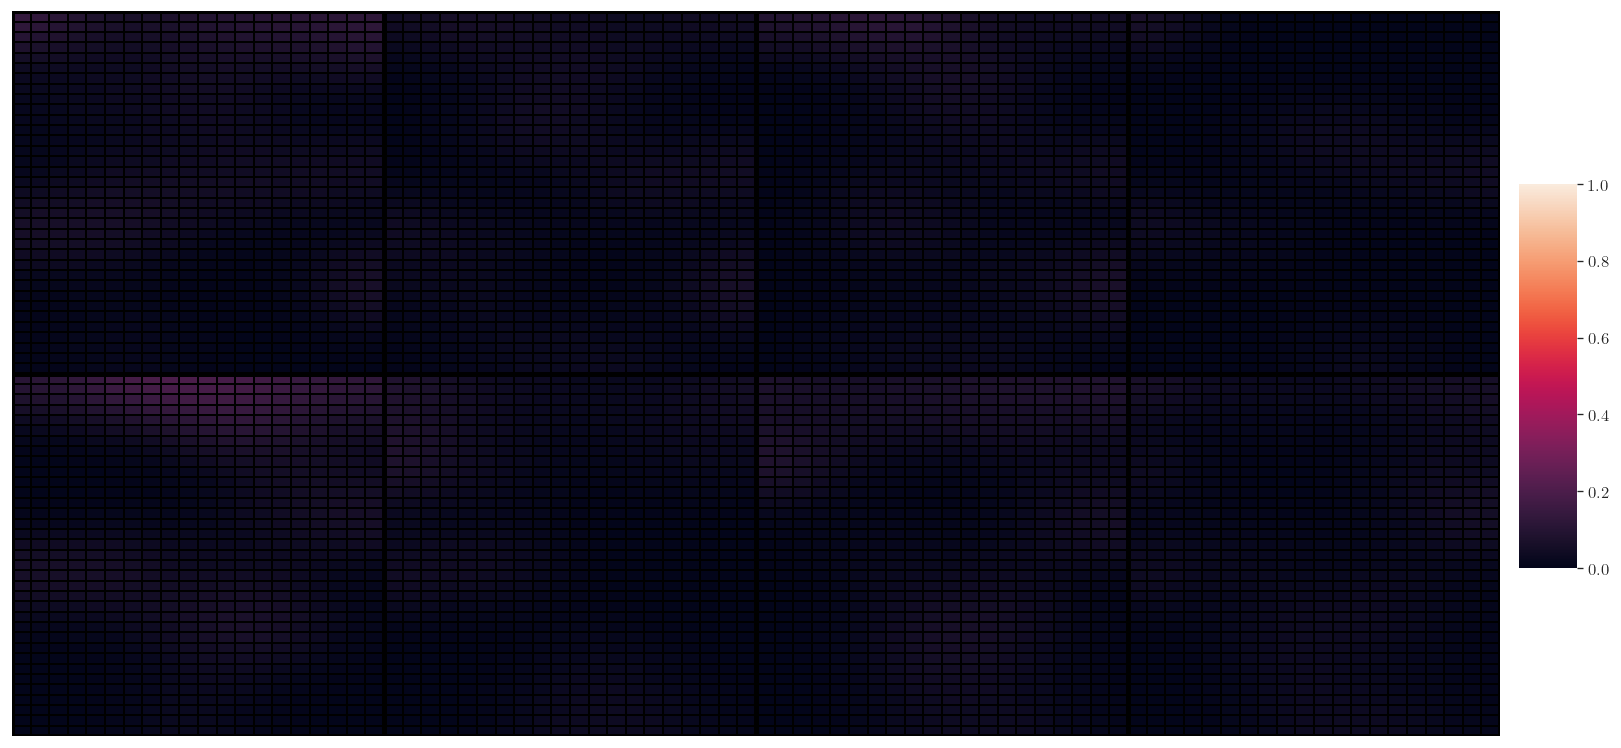

In [298]:
for plate_idx in range(8):
    cur_plate = plates[staining_sets[1][plate_idx]]
    viz_plate_property(cur_plate, "thresh_count", viz_blur=True)